<a href="https://colab.research.google.com/github/GajananKuchgave/EVA8_Assignments/blob/main/Assignment_5/EVA8_Session5_BatchNorm_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Model

In [1]:
# Load the Model

!git clone https://github.com/GajananKuchgave/EVA8_Assignments -q --quiet
!mv EVA8_Assignments/Assignment_5/*.py .
!rm -rf EVA8_Assignments

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import *

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalizationMethod='BN').to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,296
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              96
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = {"BN":[],"GN":[],"LN":[]}
test_losses = {"BN":[],"GN":[],"LN":[]}
train_acc = {"BN":[],"GN":[],"LN":[]}
test_acc = {"BN":[],"GN":[],"LN":[]}

def train(model, device, train_loader, optimizer, epoch, NormalizationName, L1Flag = False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # L1 Regularization
    if L1Flag:
        l1_lambda = 1.0e-5
        l1_loss = torch.tensor(0., requires_grad=True)
        l1_loss=l1_loss.to(device)
        for name, param in model.named_parameters():
            l1_loss = l1_loss + l1_lambda*(torch.norm(param, 1))
        loss=loss+l1_loss

    train_losses[NormalizationName].append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[NormalizationName].append(100*correct/processed)

def test(model, device, test_loader, NormalizationName):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[NormalizationName].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[NormalizationName].append(100. * correct / len(test_loader.dataset))

# Train and test our model using BN + L1 regulerization



In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net('BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, 'BN', L1Flag = True )
    scheduler.step()
    test(model, device, test_loader, 'BN')

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.15737903118133545 Batch_id=468 Accuracy=93.12: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]



Test set: Average loss: 0.0558, Accuracy: 9822/10000 (98.22%)

EPOCH: 1


Loss=0.047097478061914444 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:18<00:00, 25.16it/s]



Test set: Average loss: 0.0371, Accuracy: 9889/10000 (98.89%)

EPOCH: 2


Loss=0.027676183730363846 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:19<00:00, 24.51it/s]



Test set: Average loss: 0.0357, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.06859155744314194 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:18<00:00, 24.93it/s]



Test set: Average loss: 0.0308, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.03199460729956627 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]



Test set: Average loss: 0.0311, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.05569916218519211 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 25.27it/s]



Test set: Average loss: 0.0217, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.030593549832701683 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 24.85it/s]



Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 7


Loss=0.01359657384455204 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]



Test set: Average loss: 0.0203, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.04883074387907982 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]



Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.061967141926288605 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 24.85it/s]



Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.04304727166891098 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 24.86it/s]



Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.05851920321583748 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:18<00:00, 25.02it/s]



Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.08418580144643784 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]



Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.045377615839242935 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 24.98it/s]



Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.01817113719880581 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 24.75it/s]



Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Loss=0.022027527913451195 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s]



Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.014597255736589432 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]



Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.017641320824623108 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]



Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Loss=0.018282607197761536 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.035380616784095764 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]



Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)



In [10]:
# import necessary libraries
import matplotlib.pyplot as plt

# define a function to plot misclassified images
def plot_misclassified_images(model, test_loader):
    # set model to evaluation mode
    model.eval()

    misclassified_images = []
    actual_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append(data[i])
                    actual_labels.append(target[i])
                    predicted_labels.append(pred[i])

    # Plot the misclassified images
    fig = plt.figure(figsize=(10, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        plt.imshow(misclassified_images[i].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()

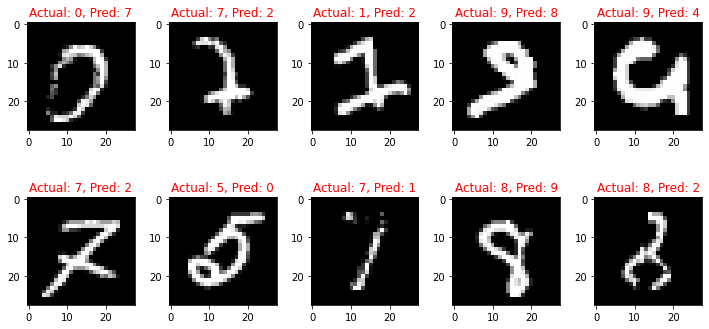

In [11]:
plot_misclassified_images(model, test_loader)

# Train and Test them model using Group Normalization

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Net('GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, NormalizationName = 'GN' )
    scheduler.step()
    test(model, device, test_loader, NormalizationName = 'GN')

EPOCH: 0


Loss=0.10678187012672424 Batch_id=468 Accuracy=92.15: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s]



Test set: Average loss: 0.0480, Accuracy: 9849/10000 (98.49%)

EPOCH: 1


Loss=0.04022460803389549 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0409, Accuracy: 9870/10000 (98.70%)

EPOCH: 2


Loss=0.0076959687285125256 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:17<00:00, 26.29it/s]



Test set: Average loss: 0.0300, Accuracy: 9902/10000 (99.02%)

EPOCH: 3


Loss=0.05709568038582802 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]



Test set: Average loss: 0.0245, Accuracy: 9928/10000 (99.28%)

EPOCH: 4


Loss=0.07025524228811264 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.036250144243240356 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]



Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

EPOCH: 6


Loss=0.0119202621281147 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]



Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 7


Loss=0.011070682667195797 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]



Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 8


Loss=0.017264077439904213 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

EPOCH: 9


Loss=0.04503875598311424 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0175, Accuracy: 9948/10000 (99.48%)

EPOCH: 10


Loss=0.004516666289418936 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.05010949447751045 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.60it/s]



Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.0057689230889081955 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]



Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.11409440636634827 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]



Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.050173401832580566 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.02482120878994465 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]



Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

EPOCH: 16


Loss=0.0026976484805345535 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.10it/s]



Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Loss=0.009704794734716415 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 18


Loss=0.06430355459451675 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.11603335291147232 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)



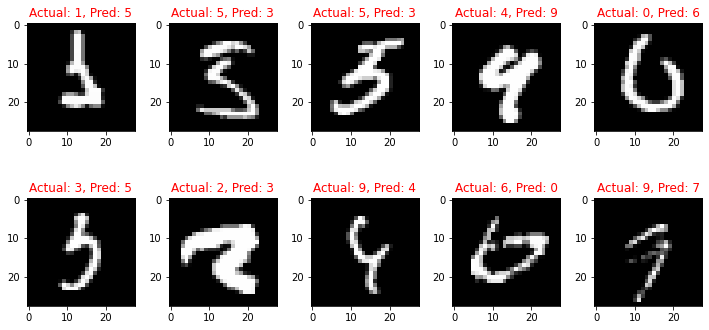

In [13]:
plot_misclassified_images(model, test_loader)

# Train and Test them model using Layer Normalization

In [14]:
from torch.optim.lr_scheduler import StepLR

model =  Net('LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, NormalizationName = 'LN' )
    scheduler.step()
    test(model, device, test_loader, NormalizationName = 'LN')

EPOCH: 0


Loss=0.09519799798727036 Batch_id=468 Accuracy=91.08: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]



Test set: Average loss: 0.0547, Accuracy: 9838/10000 (98.38%)

EPOCH: 1


Loss=0.03920072689652443 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]



Test set: Average loss: 0.0420, Accuracy: 9876/10000 (98.76%)

EPOCH: 2


Loss=0.011648007668554783 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0299, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


Loss=0.06403698772192001 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]



Test set: Average loss: 0.0294, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.018313849344849586 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]



Test set: Average loss: 0.0250, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.01116649154573679 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 6


Loss=0.008816654793918133 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]



Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

EPOCH: 7


Loss=0.027757177129387856 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]



Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

EPOCH: 8


Loss=0.0274044256657362 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 26.72it/s]



Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.024008149281144142 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0188, Accuracy: 9947/10000 (99.47%)

EPOCH: 10


Loss=0.009990166872739792 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.016897715628147125 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]



Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.06072782352566719 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]



Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.036460235714912415 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.015207468532025814 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.012787498533725739 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]



Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.04863831773400307 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]



Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


Loss=0.027538418769836426 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Loss=0.018170353025197983 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.03563477471470833 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)



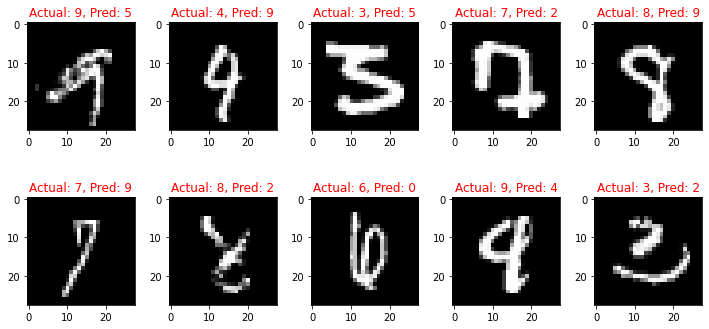

In [15]:
plot_misclassified_images(model, test_loader)

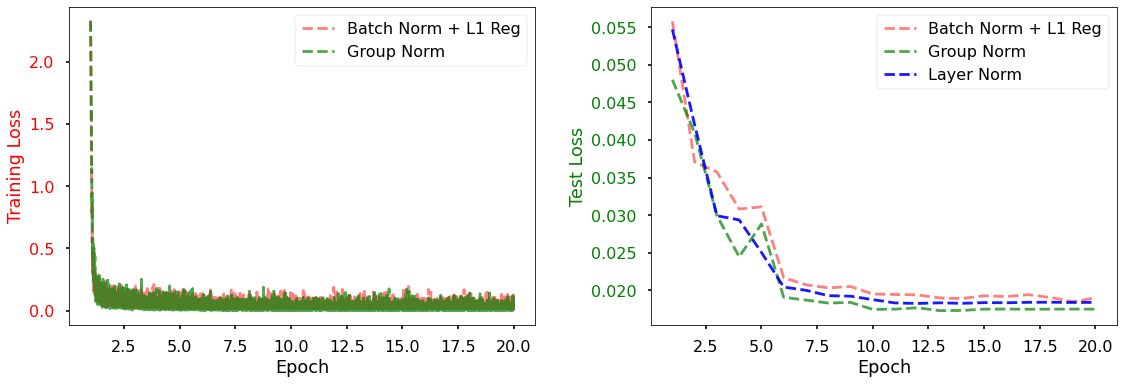

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')

fig, ax = plt.subplots(1, 2)

color1 = 'red'
color2 = 'green'
color3 = 'blue'
linestyle1 = '--'
linestyle2 = '--'
linestyle3 = '--'

train_epoch_linspace = np.linspace(1, EPOCHS, len(train_losses['GN']))
test_epoch_linspace = np.linspace(1, EPOCHS, len(test_losses['GN']))
#Left plot

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss', color=color1)
ax[0].plot(train_epoch_linspace, train_losses['BN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Batch Norm + L1 Reg')
ax[0].plot(train_epoch_linspace, train_losses['GN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Group Norm')
#ax[0].plot(train_epoch_linspace, train_losses['LN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Layer Norm')

ax[0].tick_params(axis='y', labelcolor=color1)
ax[0].legend(loc='upper right')
#Right plot

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Loss', color=color2)
ax[1].plot(test_epoch_linspace, test_losses['BN'], color=color1, linestyle=linestyle3,alpha=0.5, label='Batch Norm + L1 Reg')
ax[1].plot(test_epoch_linspace, test_losses['GN'], color=color2, linestyle=linestyle1,alpha=0.7, label='Group Norm')
ax[1].plot(test_epoch_linspace, test_losses['LN'], color=color3, linestyle=linestyle2,alpha=0.9, label='Layer Norm')

ax[1].tick_params(axis='y', labelcolor=color2)
ax[1].legend(loc='upper right')

fig.tight_layout()
fig.set_size_inches(16, 5)
plt.show()

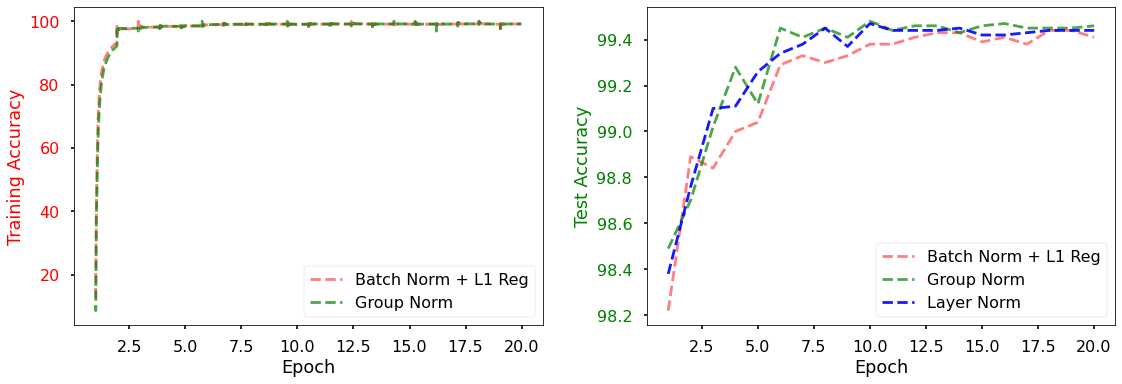

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')

fig, ax = plt.subplots(1, 2)

color1 = 'red'
color2 = 'green'
color3 = 'blue'
linestyle1 = '--'
linestyle2 = '--'
linestyle3 = '--'

train_epoch_linspace = np.linspace(1, EPOCHS, len(train_acc['BN']))
test_epoch_linspace = np.linspace(1, EPOCHS, len(test_acc['BN']))
#Left plot

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Accuracy', color=color1)
ax[0].plot(train_epoch_linspace, train_acc['BN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Batch Norm + L1 Reg')
ax[0].plot(train_epoch_linspace, train_acc['GN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Group Norm')
#ax[0].plot(train_epoch_linspace, train_acc['LN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Layer Norm')

ax[0].tick_params(axis='y', labelcolor=color1)
ax[0].legend(loc='lower right')
#Right plot

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Accuracy', color=color2)
ax[1].plot(test_epoch_linspace, test_acc['BN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Batch Norm + L1 Reg')
ax[1].plot(test_epoch_linspace, test_acc['GN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Group Norm')
ax[1].plot(test_epoch_linspace, test_acc['LN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Layer Norm')
ax[1].tick_params(axis='y', labelcolor=color2)
ax[1].legend(loc='lower right')

fig.tight_layout()
fig.set_size_inches(16, 5)
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")